In [1]:
%matplotlib inline
from pylab import *


In [2]:
from deficit_defs import *

Splikes version  0.1.2
Plasticnet version  0.1.6
macOS-10.16-x86_64-i386-64bit
Base Image File: asdf/bbsk081604_all_log2dog.asdf


In [3]:
def savefig(base):
    import matplotlib.pyplot as plt
    for fname in [f'Manuscript/resources/{base}.png',f'Manuscript/resources/{base}.svg']:
        print(fname)
        plt.savefig(fname, bbox_inches='tight')

In [4]:
_debug = False
if _debug:
    print("Debugging")

In [5]:
base='sims/2022-11-10'
if not os.path.exists(base):
    print(f"mkdir {base}")
    os.mkdir(base)

In [6]:
rf_size=19
#eta_mat=linspace(1e-7,5e-6,11)
eta=2e-6
blur_mat=linspace(0,8,17)
mu_c_mat=linspace(0,20,9)
sigma_c=1

print(blur_mat)
print(mu_c_mat)
number_of_neurons=20
number_of_processes=4

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7.  7.5 8. ]
[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20. ]


## Premake the image files

In [7]:
blur_mat=linspace(0,8,17)

In [8]:
base_image_file='asdf/bbsk081604_all.asdf'
print("Base Image File:",base_image_file)

normal_image=pi5.filtered_images(
                                base_image_file,
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )

for blur in blur_mat:

    Lfname=pi5.filtered_images(
                                base_image_file,
                                {'type':'blur','size':blur},
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )




Base Image File: asdf/bbsk081604_all.asdf
Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.Using cache_images/cache_images_fcf524b121311f6c8d3021738d0d9176.asdf from cache.Using cache_images/cache_images_84de1df7ec28e9fff71aa008fabc28ab.asdf from cache.Using cache_images/cache_images_9a3a8257f75df7fd8fd5b6731003da35.asdf from cache.Using cache_images/cache_images_dc449597e25b03aa549e59deb9230231.asdf from cache.Using cache_images/cache_images_a5a33890731b1a868baaebecee76c71d.asdf from cache.Using cache_images/cache_images_bfccd490ea9947384e0a7d994f955e3c.asdf from cache.Using cache_images/cache_images_6aedbf5e39e78c1beb4a47361965a2da.asdf from cache.Using cache_images/cache_images_9cead8acc8be7d3720d5d49758a4beba.asdf from cache.Using cache_images/cache_images_61ad4395acceb1fc40934928f3dcc141.asdf from cache.Using cache_images/cache_images_f1b88d5f120a7046b8e62e430edf90ad.asdf from cache.Using cache_images/cache_images_43c7077591f67b05006774599a6b41da.as

In [9]:
def blur_jitter_deficit(blur=[2.5,-1],
                        noise=[0.1,.1],
                        rf_size=19,eta=2e-6,
                        mu_c=0,sigma_c=0,    
                        mu_r=0,sigma_r=0,
                        number_of_neurons=10,
                        total_time=8*day,
                        save_interval=1*hour):

    
    if _debug:
        total_time=1*minute
        save_interval=1*second
        
    images=[]
    dt=200*ms
    
    for bv in blur:
        if bv<=0:
            im=pi5.filtered_images(
                                base_image_file,
                                {'type':'log2dog','sd1':1,'sd2':3},
                                )
        else:
            im=pi5.filtered_images(
                                    base_image_file,
                                    {'type':'blur','size':bv},
                                    {'type':'log2dog','sd1':1,'sd2':3},
                                    )
        images.append(im)
        
        
    dt=200*ms        
    pre1=pn.neurons.natural_images_with_jitter(images[0],
                                                rf_size=rf_size,
                                                time_between_patterns=dt,
                                                sigma_r=0,
                                                sigma_c=0,
                                                buffer_c=mu_c+2*sigma_c,
                                                buffer_r=mu_r+2*sigma_r,
                                                verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(images[1],
                                                rf_size=rf_size,
                                                other_channel=pre1,
                                                time_between_patterns=dt,
                                                mu_r=mu_r,mu_c=mu_c,
                                                sigma_r=sigma_r,sigma_c=sigma_c,
                                                verbose=False)



    sigma=noise
    pre1+=pn.neurons.process.add_noise_normal(0,sigma)

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,sigma)

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=dt

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]

In [9]:
def run_one(params,overwrite=False):
    import plasticnet as pn
    count,eta,noise,blur,number_of_neurons,sfname,mu_c,sigma_c=(params.count,params.eta,params.noise,params.blur,
                                        params.number_of_neurons,params.sfname,params.mu_c,params.sigma_c)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()

    t=16*day*2
    ts=1*hour

    # DEBUG
    if _debug:
        t=1*minute
        ts=1*second
    
    seq+=blur_jitter_deficit(blur=[blur,-1],
                                total_time=t,
                                noise=noise,eta=eta,number_of_neurons=number_of_neurons,
                                mu_c=mu_c,sigma_c=sigma_c,
                                save_interval=ts)

    
    seq.run(display_hash=False)
    pn.save(sfname,seq) 
    
    return sfname
    


In [10]:
total_time=8*day
real_time=5*60+ 55

In [11]:
from collections import namedtuple
params = namedtuple('params', ['count', 'eta','noise','blur','number_of_neurons','sfname','mu_c','sigma_c'])
all_params=[]
count=0
eta_count=0
noise_count=0
open_eye_noise=0.0

for mu_count,mu_c in enumerate(mu_c_mat):
    for blur_count,blur in enumerate(blur_mat):
        all_params.append(params(count=count,
                         eta=eta,
                             blur=blur,
                         noise=open_eye_noise,
                         number_of_neurons=number_of_neurons,
                        sfname=f'{base}/deficit %d neurons logdog %d eta %d noise %d blur %d mu_c %d sigma_c.asdf' % 
                                 (number_of_neurons,eta_count,noise_count,blur_count,mu_c,sigma_c),
                        mu_c=mu_c,
                            sigma_c=sigma_c,
                                ))
        
        count+=1
        
for a in all_params[:5]:
    print(a)
print("[....]")
for a in all_params[-5:]:
    print(a)

print(len(all_params))

print(time2str(real_time*len(all_params)/number_of_processes))


params(count=0, eta=2e-06, noise=0.0, blur=0.0, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 0 blur 0 mu_c 1 sigma_c.asdf', mu_c=0.0, sigma_c=1)
params(count=1, eta=2e-06, noise=0.0, blur=0.5, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 1 blur 0 mu_c 1 sigma_c.asdf', mu_c=0.0, sigma_c=1)
params(count=2, eta=2e-06, noise=0.0, blur=1.0, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 2 blur 0 mu_c 1 sigma_c.asdf', mu_c=0.0, sigma_c=1)
params(count=3, eta=2e-06, noise=0.0, blur=1.5, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 3 blur 0 mu_c 1 sigma_c.asdf', mu_c=0.0, sigma_c=1)
params(count=4, eta=2e-06, noise=0.0, blur=2.0, number_of_neurons=20, sfname='sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 4 blur 0 mu_c 1 sigma_c.asdf', mu_c=0.0, sigma_c=1)
[....]
params(count=148, eta=2e-06, noise=0.0, blur=6.0, number_of_neu

In [12]:
do_params=make_do_params(all_params)
len(do_params)

0

In [27]:
%%time
run_one(all_params[0],overwrite=True)

Using cache_images/cache_images_fcf524b121311f6c8d3021738d0d9176.asdf from cache.Using cache_images/cache_images_26c21bb98ee35e2306d1fd04c30276c2.asdf from cache.[.] Sequence Time Elapsed...5 m, 44.02 s
CPU times: user 5min 45s, sys: 1.14 s, total: 5min 46s
Wall time: 5min 47s


'sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 0 blur 0 mu_c 1 sigma_c.asdf'

In [13]:
if do_params:
    pool = Pool(processes=number_of_processes)
    result = pool.map_async(run_one, do_params)
    print(result.get())

## View the sims

In [17]:
sfname=all_params[0].sfname

sfname=[params for params in all_params if
    params.mu_c==20 and
    params.blur==0.0
][0].sfname
sfname

'sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 0 blur 20 mu_c 1 sigma_c.asdf'

In [18]:

R=Results(sfname)

In [20]:
R.μσ

([array([15.19033086, 19.79879083])], [array([3.51191715, 3.34440079])])

In [21]:
t,y,θ,W=R[16*day]

/Users/bblais/tmp/ipykernel_32775/3456891181.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pcolormesh(w_im[n,c,...],cmap=py.cm.gray,


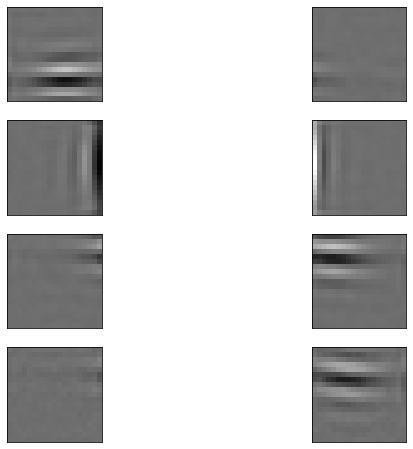

In [22]:
vmin=W.min()
vmax=W.max()

w_im=R.weight_image(W)
count=1
for n in range(4):
    for c in range(2):
        subplot(4,2,count)
        pcolormesh(w_im[n,c,...],cmap=py.cm.gray,
                        vmin=vmin,vmax=vmax)
        ax2=gca()
        ax2.set_aspect('equal')
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.xaxis.set_ticks_position('none') 
        ax2.yaxis.set_ticks_position('none') 
        
        count+=1


In [26]:
RR={}
count=0
for mu_count,mu_c in tqdm(enumerate(mu_c_mat)):
    for blur_count,blur in enumerate(blur_mat):
        params=all_params[count]
        count+=1
        RR[params.sfname]=Results(params.sfname)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

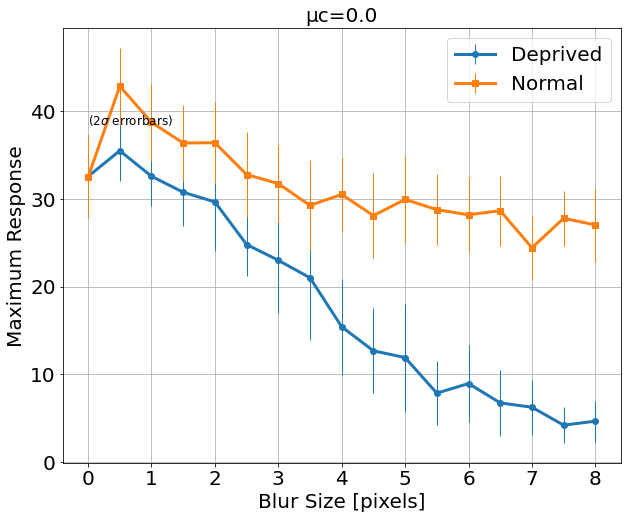

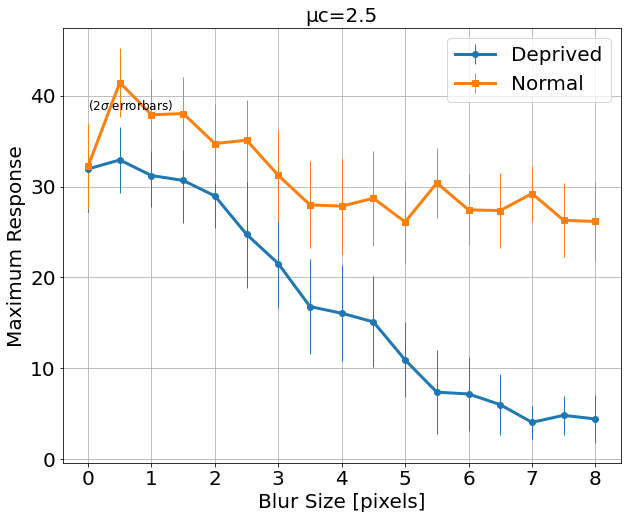

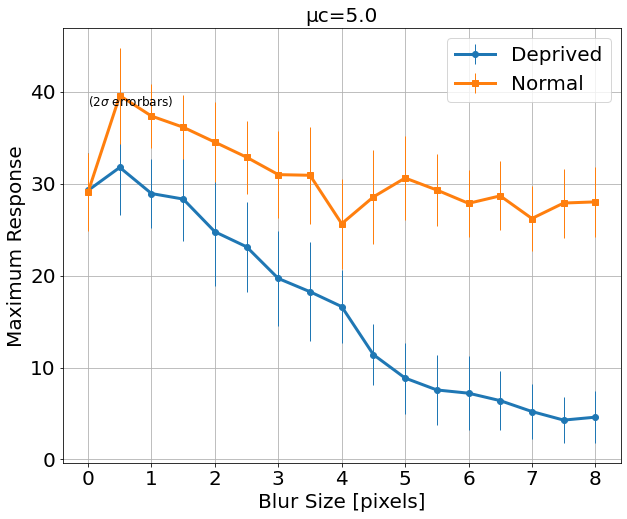

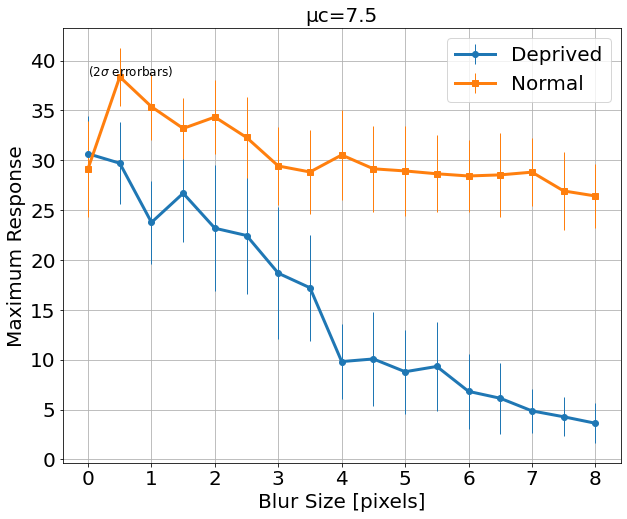

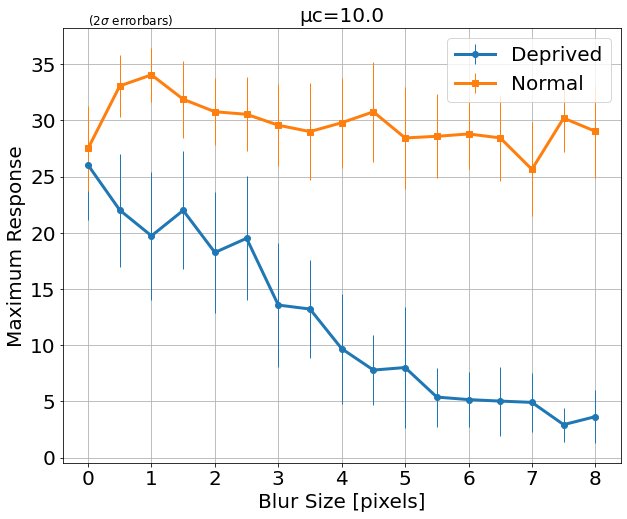

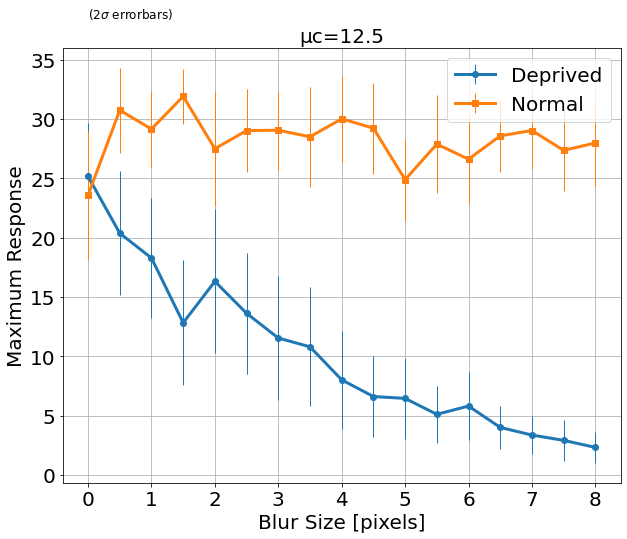

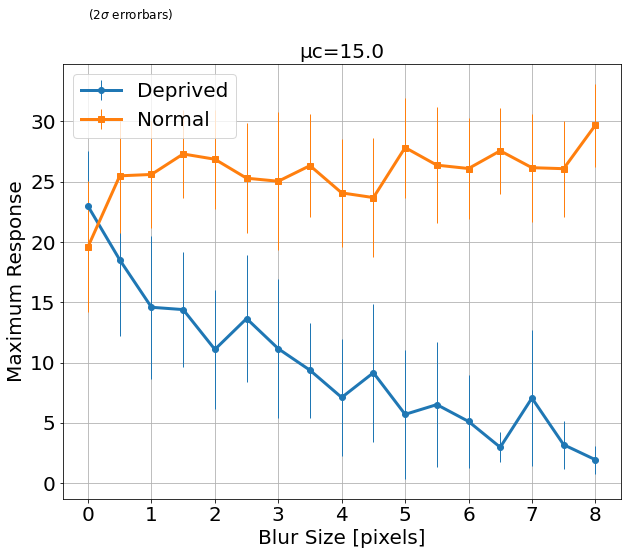

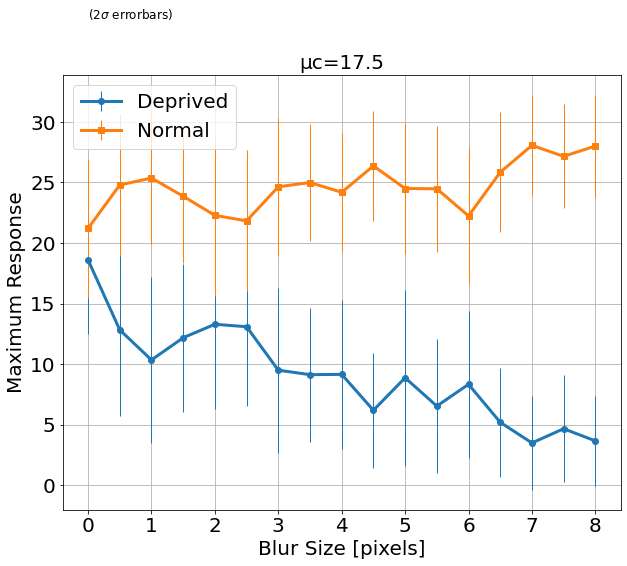

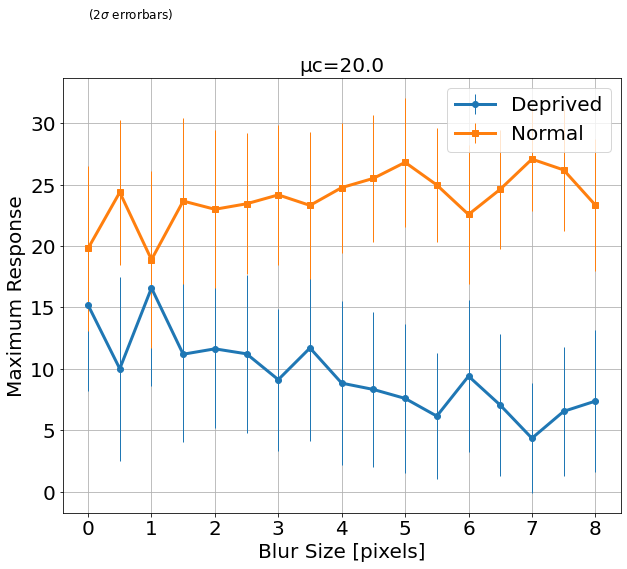

In [27]:

count=0
for mu_count,mu_c in tqdm(enumerate(mu_c_mat)):
    s=Storage()
    for blur_count,blur in enumerate(blur_mat):
        params=all_params[count]
        count+=1
        R=RR[params.sfname]
        blur=params.blur
        μ1,μ2=R.μσ[0][0]
        σ1,σ2=R.μσ[1][0]

        s+=blur,μ1,μ2,σ1,σ2
    
    
    blur,μ1,μ2,σ1,σ2=s.arrays()
    
    figure()
    errorbar(blur,μ1,yerr=2*σ1,marker='o',elinewidth=1,label='Deprived')
    errorbar(blur,μ2,yerr=2*σ2,marker='s',elinewidth=1,label='Normal')
    xlabel('Blur Size [pixels]')
    ylabel('Maximum Response')
    text(0,38.5,r'($2\sigma$ errorbars)',fontsize=12)
    title(f'μc={mu_c}')
    legend()    

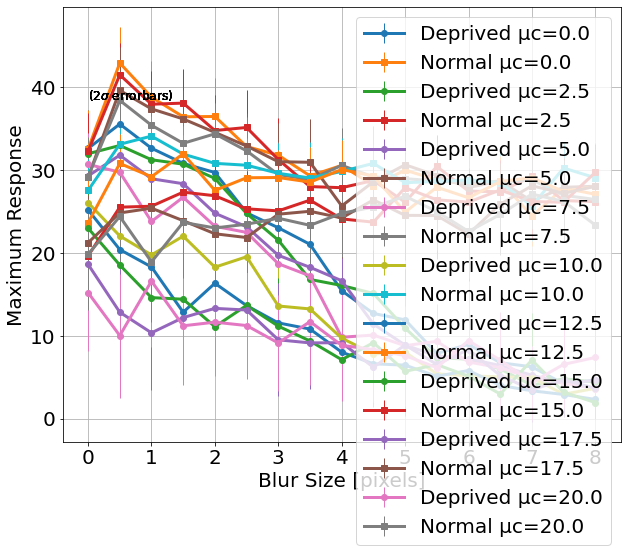

In [29]:
count=0
for mu_count,mu_c in enumerate(mu_c_mat):
    s=Storage()
    for blur_count,blur in enumerate(blur_mat):
        params=all_params[count]
        count+=1
        R=RR[params.sfname]
        blur=params.blur
        μ1,μ2=R.μσ[0][0]
        σ1,σ2=R.μσ[1][0]

        s+=blur,μ1,μ2,σ1,σ2
    
    
    blur,μ1,μ2,σ1,σ2=s.arrays()
    
    errorbar(blur,μ1,yerr=2*σ1,marker='o',elinewidth=1,label=f'Deprived μc={mu_c}')
    errorbar(blur,μ2,yerr=2*σ2,marker='s',elinewidth=1,label=f'Normal μc={mu_c}')
    xlabel('Blur Size [pixels]')
    ylabel('Maximum Response')
    text(0,38.5,r'($2\sigma$ errorbars)',fontsize=12)
legend()    

Manuscript/resources/fig-deficit-mu_c-blur.png
Manuscript/resources/fig-deficit-mu_c-blur.svg


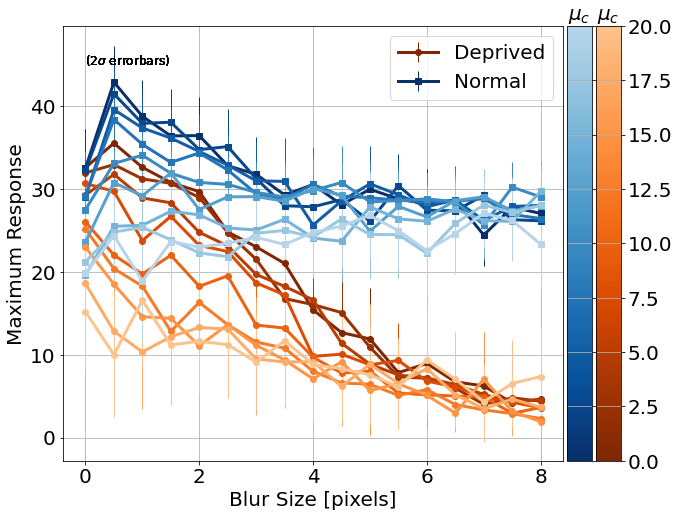

In [69]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

Blues2 = truncate_colormap(cm.Blues, 0.3, 1.0).reversed()
Oranges2 = truncate_colormap(cm.Oranges, 0.3, 1.0).reversed()

count=0
v=np.flip(linspace(0.3,1,len(mu_c_mat)))

for mu_count,mu_c in enumerate(mu_c_mat):
    s=Storage()
    for blur_count,blur in enumerate(blur_mat):
        params=all_params[count]
        count+=1
        R=RR[params.sfname]
        blur=params.blur
        μ1,μ2=R.μσ[0][0]
        σ1,σ2=R.μσ[1][0]

        s+=blur,μ1,μ2,σ1,σ2
    
    
    blur,μ1,μ2,σ1,σ2=s.arrays()
    
    if mu_count==0:
        errorbar(blur,μ1,yerr=2*σ1,marker='o',elinewidth=1,label=f'Deprived',color=cm.Oranges(v[mu_count]))
        errorbar(blur,μ2,yerr=2*σ2,marker='s',elinewidth=1,label=f'Normal',color=cm.Blues(v[mu_count]))
    else:
        errorbar(blur,μ1,yerr=2*σ1,marker='o',elinewidth=1,color=cm.Oranges(v[mu_count]))
        errorbar(blur,μ2,yerr=2*σ2,marker='s',elinewidth=1,color=cm.Blues(v[mu_count]))
    xlabel('Blur Size [pixels]')
    ylabel('Maximum Response')
    text(0,45,r'($2\sigma$ errorbars)',fontsize=12)

legend()

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)   
ax_cb.grid(False)
ax_cb2 = divider.new_horizontal(size="5%", pad=0.05)    
ax_cb2.grid(False)
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=Blues2,norm=mpl.colors.Normalize(vmin=mu_c_mat[0], vmax=mu_c_mat[-1]),orientation='vertical')
cb2 = mpl.colorbar.ColorbarBase(ax_cb2, cmap=Oranges2,norm=mpl.colors.Normalize(vmin=mu_c_mat[0], vmax=mu_c_mat[-1]),orientation='vertical')
plt.gcf().add_axes(ax_cb)
ax_cb.grid(True)
ax_cb.set_yticklabels([])
ax_cb2.grid(True)
title(r'$\mu_c$')
plt.gcf().add_axes(ax_cb2)
title(r'$\mu_c$')

savefig('fig-deficit-mu_c-blur')



In [70]:
sfname

'sims/2022-11-03/deficit 20 neurons logdog 0 eta 0 noise 0 blur 20 mu_c 1 sigma_c.asdf'

In [75]:
R=RR[params.sfname]
μ,σ=μσ(R.ODI[-1])
μ,σ

(0.5393773116165972, 0.16084706039334304)

Manuscript/resources/fig-deficit-ODI-mu_c-blur.png
Manuscript/resources/fig-deficit-ODI-mu_c-blur.svg


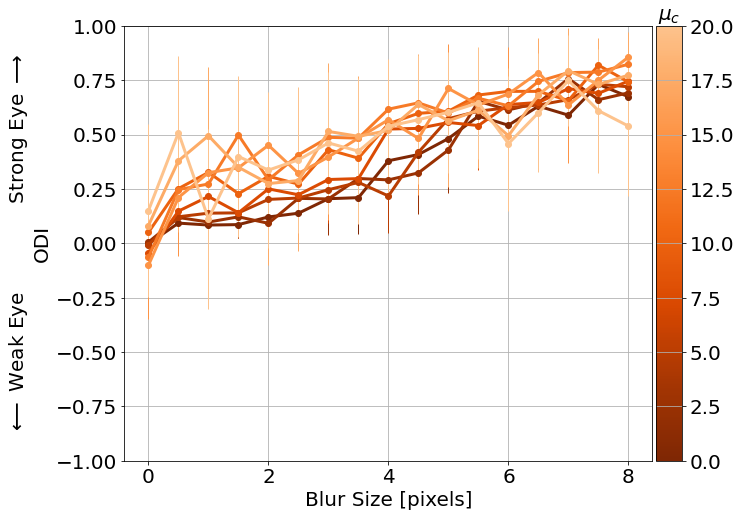

In [80]:
count=0
v=np.flip(linspace(0.3,1,len(mu_c_mat)))

for mu_count,mu_c in enumerate(mu_c_mat):
    s=Storage()
    for blur_count,blur in enumerate(blur_mat):
        params=all_params[count]
        count+=1
        R=RR[params.sfname]
        blur=params.blur
        μ,σ=μσ(R.ODI[-1])

        s+=blur,μ,σ
    
    
    blur,μ,σ=s.arrays()
    errorbar(blur,μ,yerr=2*σ,marker='o',elinewidth=1,color=cm.Oranges(v[mu_count]))    
    xlabel('Blur Size [pixels]')
    ylabel(r'$\longleftarrow$ Weak Eye              Strong Eye $\longrightarrow$'+"\nODI")
    ylim([-1,1])

divider = make_axes_locatable(plt.gca())
ax_cb2 = divider.new_horizontal(size="5%", pad=0.05)    
ax_cb2.grid(False)
cb2 = mpl.colorbar.ColorbarBase(ax_cb2, cmap=Oranges2,norm=mpl.colors.Normalize(vmin=mu_c_mat[0], vmax=mu_c_mat[-1]),orientation='vertical')
ax_cb2.grid(True)
plt.gcf().add_axes(ax_cb2)
title(r'$\mu_c$')

savefig('fig-deficit-ODI-mu_c-blur')



In [36]:
cmap

array([[0.03137255, 0.18823529, 0.41960784, 1.        ],
       [0.03137255, 0.27755479, 0.55223376, 1.        ],
       [0.0686659 , 0.36538255, 0.64905805, 1.        ],
       [0.14260669, 0.45633218, 0.71660131, 1.        ],
       [0.23192618, 0.54565167, 0.76261438, 1.        ],
       [0.33637832, 0.62551326, 0.80673587, 1.        ],
       [0.46039216, 0.70474433, 0.8480123 , 1.        ],
       [0.59843137, 0.78053057, 0.87778547, 1.        ],
       [0.71618608, 0.83320261, 0.91615532, 1.        ]])

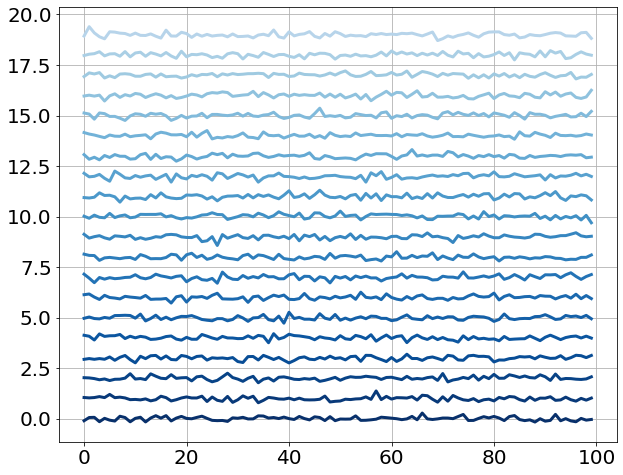

In [37]:
v=np.flip(linspace(0.3,1,20))
for i in range(20):
    color=cm.Blues(v[i])
    plot(randn(100)*.1+i,color=color)

In [30]:
v=linspace(0.5,1,20)

In [31]:
v

array([0.5       , 0.52631579, 0.55263158, 0.57894737, 0.60526316,
       0.63157895, 0.65789474, 0.68421053, 0.71052632, 0.73684211,
       0.76315789, 0.78947368, 0.81578947, 0.84210526, 0.86842105,
       0.89473684, 0.92105263, 0.94736842, 0.97368421, 1.        ])

In [34]:
np.flip(v)

array([1.        , 0.97368421, 0.94736842, 0.92105263, 0.89473684,
       0.86842105, 0.84210526, 0.81578947, 0.78947368, 0.76315789,
       0.73684211, 0.71052632, 0.68421053, 0.65789474, 0.63157895,
       0.60526316, 0.57894737, 0.55263158, 0.52631579, 0.5       ])

In [35]:
v

array([0.5       , 0.52631579, 0.55263158, 0.57894737, 0.60526316,
       0.63157895, 0.65789474, 0.68421053, 0.71052632, 0.73684211,
       0.76315789, 0.78947368, 0.81578947, 0.84210526, 0.86842105,
       0.89473684, 0.92105263, 0.94736842, 0.97368421, 1.        ])

In [67]:
cm.Blues(0.3)

(0.7161860822760477, 0.8332026143790849, 0.916155324875048, 1.0)